In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

In [18]:
length_tasks = 10
num_inputs = 2
sigma_y = 0.1
num_tasks = 1000

def generate_task(num_inputs, length_tasks, sigma_y):
    true_weights = np.random.randn(num_inputs, 1)
    inputs = np.random.randn(length_tasks, num_inputs)
    targets = inputs @ true_weights + sigma_y * np.random.randn(length_tasks, 1)
    return inputs, targets

### Exercise 2.1

Implement the predict() and learn() functions of the Rescorla-Wagner model. Run the model and plot the resulting squared error over trials (averaged over multiple tasks).

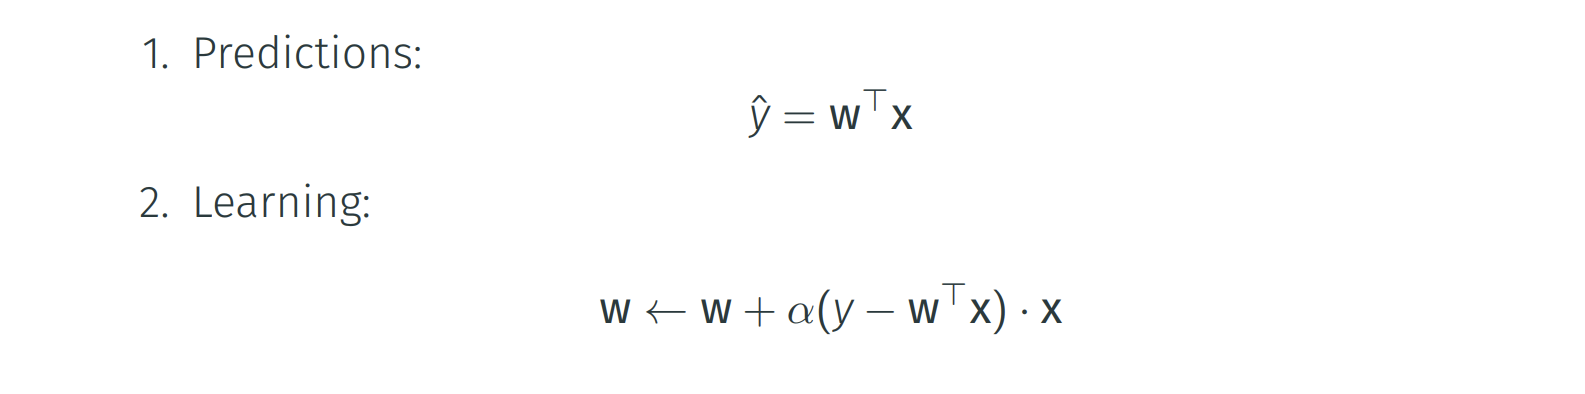

In [16]:
class RescorlaWagner():
    def __init__(self, num_inputs, sigma_y, learning_rate):
        self.num_inputs = num_inputs
        self.sigma_y = sigma_y
        self.learning_rate = learning_rate
        
        self.weights = np.zeros((num_inputs, 1))
        
    # TODO implement this function
    def predict(self, inputs):
        return self.weights.T @ inputs
        
    # TODO implement this function
    def learn(self, inputs, targets):
        self.weights = self.weights + self.learning_rate * (targets - self.predict(inputs)) * inputs

In [59]:
# store performance
mse = np.zeros((num_tasks, length_tasks))

for task in tqdm(range(num_tasks)):
    
    # generate some data
    inputs, targets = generate_task(num_inputs, length_tasks, sigma_y)
    
    # initialize the model
    model = RescorlaWagner(num_inputs, sigma_y, learning_rate=0.25)
    
    # iterate over each task    
    for trial in range(length_tasks):
        
        mean = model.predict(inputs[[trial], :].T)
        
        # store performance measured by squared error
        mse[task, trial] = ((targets[[trial], :] - mean) ** 2)[0, 0]
        
        model.learn(inputs[[trial], :].T, targets[[trial], :])

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2019.02it/s]


Text(0.5, 1.0, 'MSE of the  Rescorla-Wagner agent \n averaged over multiple runs of the task')

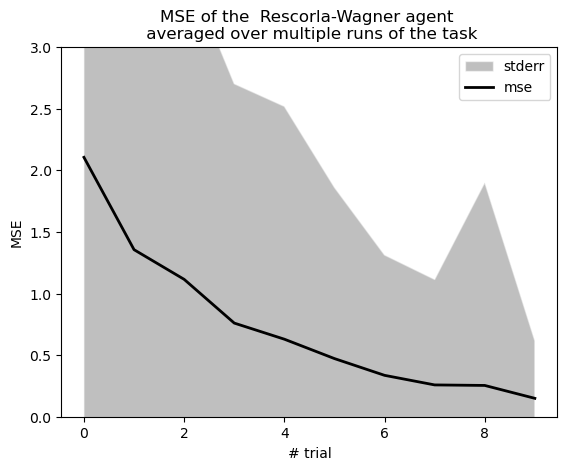

In [60]:
# plotting

means = mse.mean(axis=0)
stds = mse.std(axis=0)

plt.fill_between(np.arange(length_tasks), means - stds, means + stds, edgecolor='white', facecolor='gray', alpha=0.5, label='stderr')
plt.plot(means, color='black', linewidth=2, label='mse')
#plt.scatter(np.tile(np.arange(length_tasks), (num_tasks, 1)).flatten(), mse.flatten(), c='black', alpha=0.01, facecolors='none')
plt.ylim((0, 3))
plt.xlabel("# trial")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the  Rescorla-Wagner agent \n averaged over multiple runs of the task")

### Exercise 2.2

Implement the predict() and learn() functions of the Kalman filter. Run the model and plot the resulting  squared error over trials (averaged over multiple tasks).

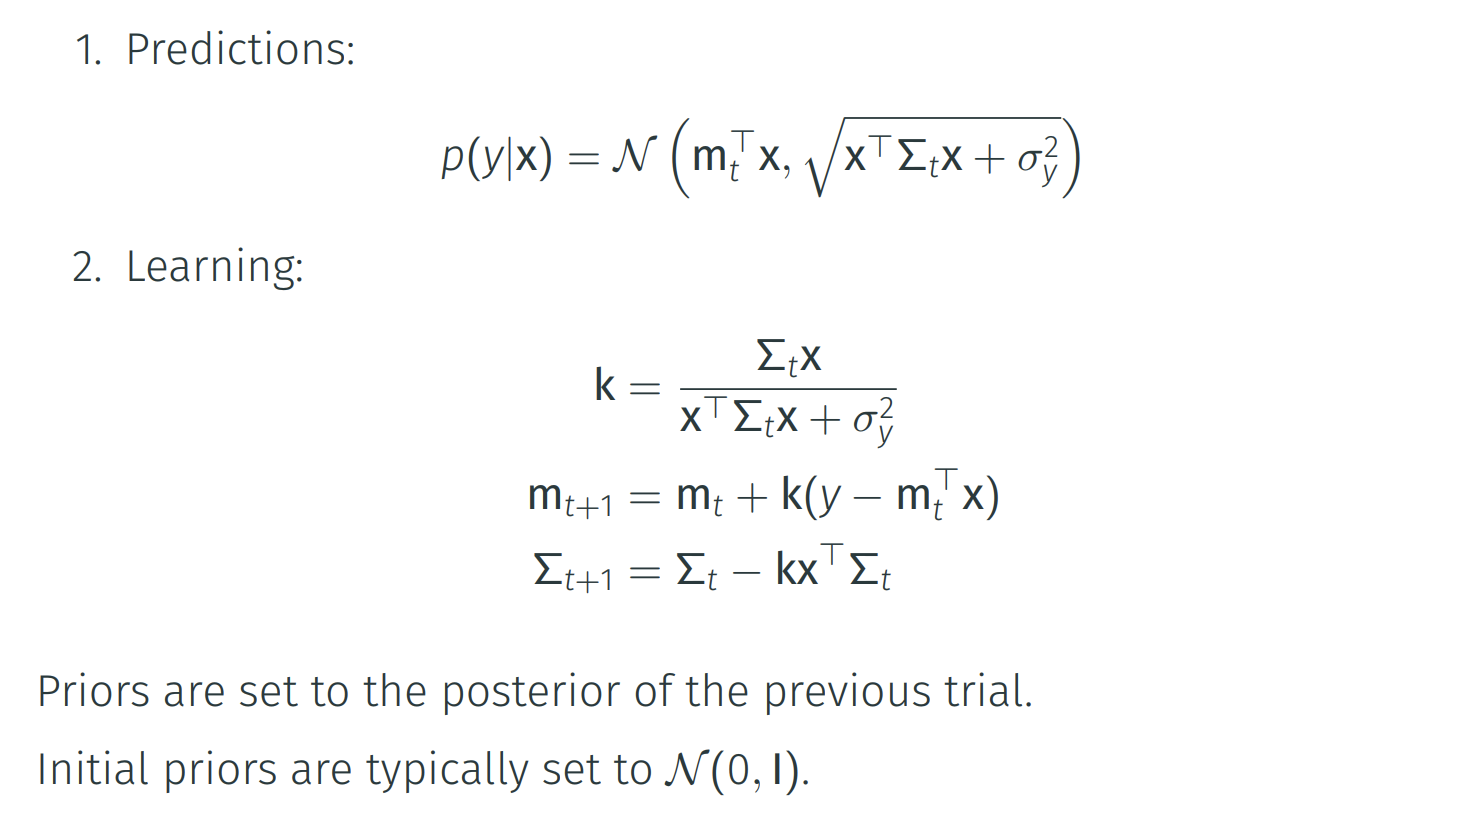

In [34]:
class KalmanFilter():
    def __init__(self, num_inputs, sigma_y, sigma_w):
        self.num_inputs = num_inputs
        self.sigma_y = sigma_y
        self.sigma_w = sigma_w
        
        self.weights = np.zeros((num_inputs, 1))
        self.covariance = sigma_w * np.eye(num_inputs)
        
    # TODO implement this function
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        std = np.sqrt(inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        return mean, std
        
    # TODO implement this function
    def learn(self, inputs, targets):
        gain = self.covariance @ inputs / (inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        self.weights = self.weights + gain * (targets - self.weights.T @ inputs)
        self.covariance = self.covariance - gain * inputs.T @ self.covariance
        
        


In [62]:
# store performance
mse = np.zeros((num_tasks, length_tasks))

for task in range(num_tasks):
    
    # generate some data
    inputs, targets = generate_task(num_inputs, length_tasks, sigma_y)
    
    # initialize the model
    model = KalmanFilter(num_inputs, sigma_y, sigma_w=1)
    
    # iterate over each task    
    for trial in range(length_tasks):
        
        mean, std = model.predict(inputs[[trial], :].T)
        
        # store performance measured by squared error
        mse[task, trial] = ((targets[[trial], :] - mean) ** 2)[0, 0]
        
        model.learn(inputs[[trial], :].T, targets[[trial], :])

Text(0.5, 1.0, 'MSE of the Kalman filter-based agent \n averaged over multiple runs of the task')

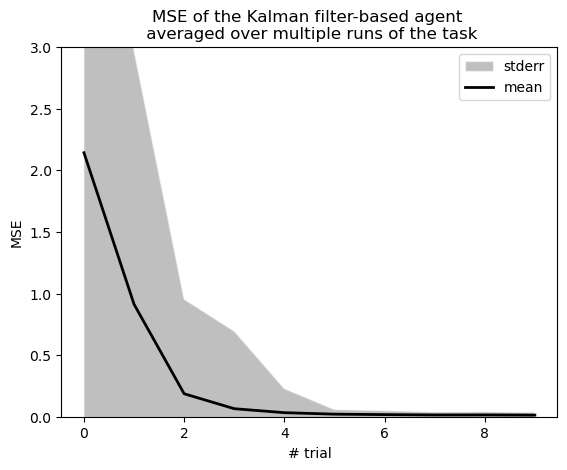

In [64]:
# plotting

means = mse.mean(axis=0)
stds = mse.std(axis=0)

plt.fill_between(np.arange(length_tasks), means - stds, means + stds, edgecolor='white', facecolor='gray', alpha=0.5, label='stderr')
plt.plot(means, color='black', linewidth=2, label='mean')
#plt.scatter(np.tile(np.arange(length_tasks), (num_tasks, 1)).flatten(), mse.flatten(), c='black', alpha=0.01, facecolors='none')
plt.ylim((0, 3))
plt.xlabel("# trial")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the Kalman filter-based agent \n averaged over multiple runs of the task")

How can we determine which of these learning algorithms a subject in an experiment is using? One way to accomplish this is to construct a task where the two models make different predictions. The backward blocking paradigm from the associative learning literature is such a task. It involves two phases. In the first phase, two stimuli are repeatedly presented with a reward. In the second phase, only the first stimulus is presented with a reward (i.e., the second stimulus is omitted). Experimentally it has been observed that animals respond weaker to the second stimulus after the end of the second phase (compared to at the end of the first phase), even though this stimulus has never been directly observed in the second phase.

### Exercise 2.3a

Hypothesize, based on their updating equations, which of the two models aligns with the previously described experimental result.

In [65]:
length_tasks = 10
num_inputs = 2

def generate_blocking_data(num_inputs, length_tasks):
    inputs = np.zeros((length_tasks * 2, num_inputs))
    inputs[:length_tasks,] = 1
    inputs[length_tasks:, 0] = 1

    targets = np.ones((length_tasks * 2, 1))
    return inputs, targets

In [73]:
# store performance
weights = np.zeros((2, length_tasks * 2, num_inputs, 1))
    
# initialize the model
model1 = RescorlaWagner(num_inputs, sigma_y=0.1, learning_rate=0.2)
model2 = KalmanFilter(num_inputs, sigma_y=0.1, sigma_w=1)

# generate blocking data
inputs, targets = generate_blocking_data(num_inputs, length_tasks)

# iterate over each task    
for trial in range(length_tasks * 2):
    # TODO simulate both models on the blocking data
    
    # Rescorla-Wagner
    #mean = model1.predict(inputs[[trial], :].T)
    #mse[task, trial] = ((targets[[trial], :] - mean) ** 2)[0, 0]  
    model1.learn(inputs[[trial], :].T, targets[[trial], :])
    weights[0, trial, :] = model1.weights
    
    # Kalman filter
    #mean, std = model2.predict(inputs[[trial], :].T)
    #mse[task, trial] = ((targets[[trial], :] - mean) ** 2)[0, 0]
    model2.learn(inputs[[trial], :].T, targets[[trial], :])
    weights[1, trial, :] = model2.weights

### Exercise 2.3b

Then, simulate both models on the backward blocking paradigm. Plot how the weight that corresponds to the second stimulus changes over trials. Did your simulations confirm your hypothesis?

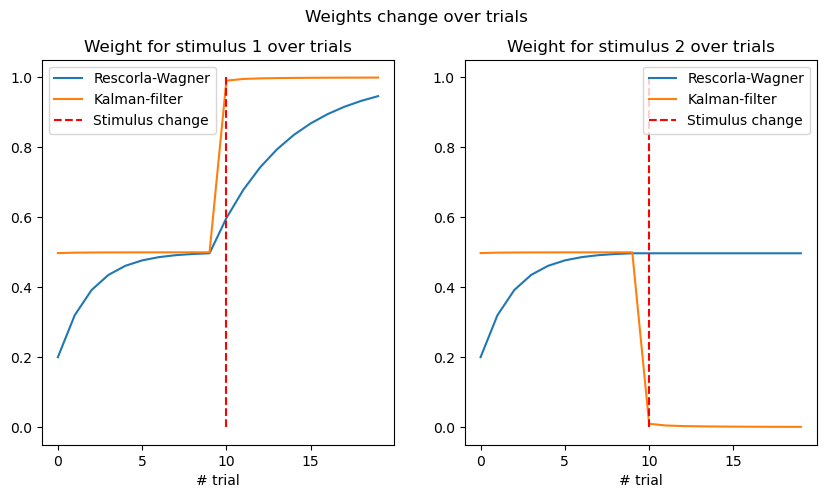

In [77]:
i_stim = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.suptitle("Weights change over trials")

for i_stim in [0, 1]:
    ax = axes[i_stim]
    ax.plot(weights[0, :, i_stim], label="Rescorla-Wagner")
    ax.plot(weights[1, :, i_stim], label="Kalman-filter")
    ax.vlines(length_tasks, 0, 1, linestyle='--', color='red', label='Stimulus change')
    ax.set_title(f"Weight for stimulus {i_stim + 1} over trials")
    ax.legend()
    ax.set_xlabel("# trial")

*Rescorla-Wagner model lacks the component of "forgetting". When the weight for the stimulus is learned, if only the other stimulus is present, the 2nd stimulus' weight does not update, because there is no prediction error corresponding to this weight. To be honest it is quite difficult to interpret discrete time diffeqs (update equations). I don't see why Kalman filter agent behaves that way since the update rule for mean of the weights is very similar to that of the RW model.*